In [137]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

def get_lscale_vs_t(directory,flist,thresh=0.2,plane=0):
    mat = np.zeros([len(flist),4])

    for i,fname in enumerate(flist):
        tID = fname.split('_')[-1]
        tID = int(tID.split('.dat')[0])
        time = nml.read_time(directory,tID)

        # Get eta
        dtheta = get_dtheta(directory,time)
        eta = y/dtheta
        
        # Get y lengthscale
        autocorr = np.fromfile(fname,sep=' ')
        autocorr = np.reshape(autocorr,[Ny,3])
        autocorr = autocorr[:,plane]
        ly,tmp1,tmp2 = get_lscale(-y,autocorr,thresh=thresh)
        
        # Get xz lengthscale (vv only)
        # Plot the Lx,Ly lengthscales:
        x = np.linspace(0,Lx,Nx)
        z = np.linspace(0,Lz,Nz)
        if inp.rr==1:
            qname = fname.split('_')[1]
            fname = dir_out+'/autocorr_%s_%04d.h5'%(qname,tID)
            hf =  h5py.File(fname,'r')
            try:
                autocorr = np.mean(hf['qx'],axis=-1)
                autocorr = np.fft.fftshift(autocorr)
            except: 
                autocorr = hf['corrx'][:,0]
            #plt.plot(x,autocorr,label=tID)
            lx,i1,i2 = get_lscale(x,autocorr,thresh=thresh)        
            try:
                autocorr = np.mean(hf['qz'],axis=0)
                autocorr = np.fft.fftshift(autocorr)
            except: 
                autocorr = hf['corrz'][:,0]
            lz,i1,i2 = get_lscale(z,autocorr,thresh=thresh)
            #plt.plot(autocorr)
        else:
            lx = 0
            lz = 0

        # Get 99% lengthscale
        utilde = np.fromfile( directory+'shearlayer_utilde_%04d.dat'%tID, sep=' ')
        L99,i1,i2 = get_L99(-y,utilde)
        
        # Record for later
        mat[i,0] = time
        mat[i,1] = ly/L99
        mat[i,2] = lx/ly
        mat[i,3] = lz/ly
        
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]

directory = '/home/kmatsuno/ShearLayerData/production/Mc02/rr7/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
x = np.linspace(0,Lx,Nx)
z = np.linspace(0,Lz,Nz)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

# And read growth rates
tlist,dlist,rates = growth_rates(directory+'shearlayer_')

flist = glob.glob(directory+"*lscale_vv*")
flist.sort()
print([f.split('/')[-1] for f in flist])


Params for this run:
	Mc = 0.2
	Re = 1000.0
	rr = 7.0
Params for this grid:
	N = 1024x1448x512
	L = 150.0x200.0x75.0
['lscale_vv_0001.dat', 'lscale_vv_0002.dat', 'lscale_vv_0003.dat', 'lscale_vv_0004.dat', 'lscale_vv_0005.dat', 'lscale_vv_0006.dat', 'lscale_vv_0007.dat', 'lscale_vv_0008.dat', 'lscale_vv_0009.dat', 'lscale_vv_0010.dat', 'lscale_vv_0014.dat', 'lscale_vv_0015.dat', 'lscale_vv_0016.dat', 'lscale_vv_0020.dat', 'lscale_vv_0021.dat', 'lscale_vv_0022.dat', 'lscale_vv_0023.dat', 'lscale_vv_0024.dat', 'lscale_vv_0025.dat', 'lscale_vv_0026.dat', 'lscale_vv_0027.dat', 'lscale_vv_0028.dat', 'lscale_vv_0058.dat', 'lscale_vv_0059.dat', 'lscale_vv_0060.dat', 'lscale_vv_0061.dat', 'lscale_vv_0062.dat', 'lscale_vv_0063.dat', 'lscale_vv_0064.dat', 'lscale_vv_0065.dat', 'lscale_vv_0066.dat', 'lscale_vv_0067.dat', 'lscale_vv_0068.dat', 'lscale_vv_0069.dat', 'lscale_vv_0070.dat', 'lscale_vv_0071.dat', 'lscale_vv_0072.dat', 'lscale_vv_0073.dat', 'lscale_vv_0074.dat', 'lscale_vv_0075.dat', 'l

0.2:[0.358564749566,0.0690429250423],
0.2:[0.0,0.0],
0.2:[0.0,0.0],


(600, 800)

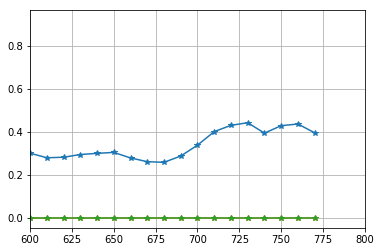

In [140]:
flist = glob.glob(directory+"*lscale_vv*")
dat = get_lscale_vs_t(directory,flist,thresh=0.1,plane=0)

plt.figure()
plt.plot(dat[:,0],dat[:,1],'-*')
plt.plot(dat[:,0],dat[:,2],'-*')
plt.plot(dat[:,0],dat[:,3],'-*')
plt.grid(True)

idx = -13
ie = None
for j in [1,2,3]:
    print('{}:[{},{}],'.format(inp.Mc,np.mean(dat[idx:ie,j]),np.std(dat[idx:ie,j])))
plt.xlim([600,800])

0.2:[0.0,0.0],
0.8:[0.0,0.0],
2.0:[0.0,0.0],
Done


Text(0.5,0,'$t/\\Delta U$')

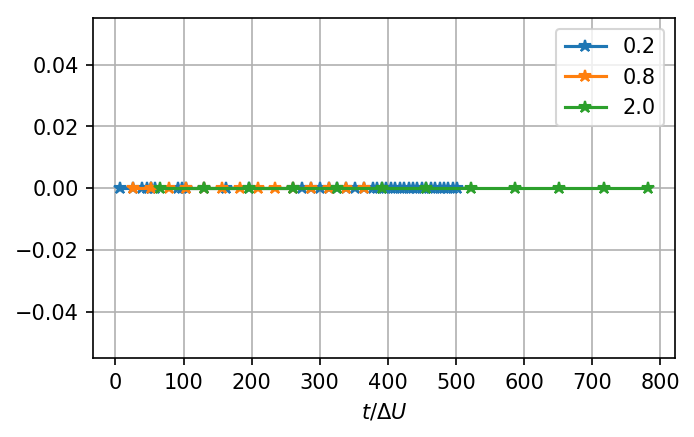

In [111]:
s = '7'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(5,3),dpi=150)
ax = plt.axes()

for Mc in Mc_list:
    if 0:#Mc is '04' or Mc is '02':
        dir_out = '/home/kmatsuno/ShearLayerData/temporal/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    else:
        dir_out = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(dir_out,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(dir_out,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    lscale = 'vv'
    flist = glob.glob(dir_out+"*lscale_%s*"%lscale)
    flist.sort()
    
    # plane 0:yc, 1:yc+L99/4, 2:yc-L99/4
    dat = get_lscale_vs_t(dir_out,flist[:],thresh=0.1,plane=0) 
    t = dat[:,0]*inp.du
    f = dat[:,3] # 1:ly/L99, 2:lx/ly, 3:lz/ly
    ax.plot(t,f,'-*',label='{}'.format(inp.Mc))
    
#     #if Mc=='02': ist=5;ien=10 # mira run
#     if Mc=='02': ist=-9;ien=-1 # theta run
#     #elif Mc=='04': ist=8;ien=14 #mira run
#     elif Mc=='04': ist=7;ien=10 #theta run
#     elif Mc=='08': ist=2;ien=8 
#     elif Mc=='12': ist=4;ien=-5
#     elif Mc=='16': ist=1;ien=None
#     elif Mc=='20': ist=0;ien=4
    if Mc=='02': ist=5;ien=10 # mira run
    elif Mc=='08': ist=2;ien=8 
    elif Mc=='20': ist=2;ien=8 

    print('{}:[{},{}],'.format(inp.Mc,np.mean(f[ist:ien]),np.std(f[ist:ien])))
    
print('Done')
ax.grid(True)
ax.legend()
ax.set_xlabel(r'$t/\Delta U$')